# Create a Curvilinear Test Grid

This notebook creates a curvilinear grid to test the xRegridHydromet program. It uses an existing WRF grid that covers the Snake River Basin and cuts out a 10 x 10 cell patch that is centered on [Albertsons Stadium](https://en.wikipedia.org/wiki/Albertsons_Stadium) on Boise State University's campus. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

src_file = './dest/id_wrf_narr_d01.nc' # An existing WRF geo_em file

ds = xr.open_dataset(src_file) # Open the grid as an xarray dataset

# Test coordinates are centered in Albertsons Stadium on Boise State's campus
lat = 43.603
lon = -116.196

testfileoutput = './tests/testdest/testdestgrid.nc'

### 1. Prepare a Dataset with Only Coordinate Variables

Extract the following grids from the dataset: 
- `XLAT_M`: 2D latitude array of WRF grid centers
- `XLONG_M`: 2D longitude array of WRF grid centers
- `XLAT_C`: 2D latitude array of WRF grid corners
- `XLONG_C`: 2D longitude array of WRF grid corners

And create a new `xArray` dataset with these grids.

In [2]:
da_xlatm = ds['XLAT_M']
da_xlongm = ds['XLONG_M']
da_xlatc = ds['XLAT_C']
da_xlongc = ds['XLONG_C']

ds_grid = da_xlatm.to_dataset()
ds_grid['XLONG_M'] = da_xlongm
ds_grid['XLAT_C'] = da_xlatc
ds_grid['XLONG_C'] = da_xlongc

print(ds_grid)

<xarray.Dataset>
Dimensions:  (Time: 1, south_north: 289, west_east: 339, south_north_stag: 290, west_east_stag: 340)
Dimensions without coordinates: Time, south_north, west_east, south_north_stag, west_east_stag
Data variables:
    XLAT_M   (Time, south_north, west_east) float32 ...
    XLONG_M  (Time, south_north, west_east) float32 ...
    XLAT_C   (Time, south_north_stag, west_east_stag) float32 ...
    XLONG_C  (Time, south_north_stag, west_east_stag) float32 ...


### 2. Get a 10 x 10 Patch of Grid Cells
#### 2.1 Get a Measure of Distance from Grid Centers to Target Coordinate

In [3]:
abslat = np.abs(ds_grid.XLAT_M - lat)
abslon = np.abs(ds_grid.XLONG_M - lon)
c = np.maximum(abslon, abslat)

#### 2.2 Get the Indices of the Grid Cell Closest to Target 

In [4]:
([tloc],[yloc],[xloc]) = np.where(c == np.min(np.squeeze(c, axis=0)))

In [5]:
print(xloc)
print(yloc)

129
119


#### 2.3 Get 10 x 10 Cells in West-East and South-North Centered on Target

In [6]:
da_xlatm_test = ds_grid['XLAT_M'].sel(south_north=slice(yloc-5,yloc+5),west_east=slice(xloc-5,xloc+5))
da_xlongm_test = ds_grid['XLONG_M'].sel(south_north=slice(yloc-5,yloc+5),west_east=slice(xloc-5,xloc+5))
da_xlatc_test = ds_grid['XLAT_C'].sel(south_north_stag=slice(yloc-5,yloc+6),west_east_stag=slice(xloc-5,xloc+6))
da_xlongc_test = ds_grid['XLONG_C'].sel(south_north_stag=slice(yloc-5,yloc+6),west_east_stag=slice(xloc-5,xloc+6))



#### 2.4 Create a New `xArray` Dataset from this Patch

In [7]:
ds_grid_test = da_xlatm_test.to_dataset()
ds_grid_test['XLONG_M'] = da_xlongm_test
ds_grid_test['XLAT_C'] = da_xlatc_test
ds_grid_test['XLONG_C'] = da_xlongc_test
print(ds_grid_test)

<xarray.Dataset>
Dimensions:  (Time: 1, south_north: 10, west_east: 10, south_north_stag: 11, west_east_stag: 11)
Dimensions without coordinates: Time, south_north, west_east, south_north_stag, west_east_stag
Data variables:
    XLAT_M   (Time, south_north, west_east) float32 43.48 43.48 ... 43.72 43.73
    XLONG_M  (Time, south_north, west_east) float32 -116.4 -116.3 ... -116.0
    XLAT_C   (Time, south_north_stag, west_east_stag) float32 ...
    XLONG_C  (Time, south_north_stag, west_east_stag) float32 ...


#### 2.5 Save Test Grid to `NetCDF` File

In [8]:
ds_grid_test.to_netcdf(testfileoutput)

### 3. Plot Target, Test Grid Centers, Test Grid Corners

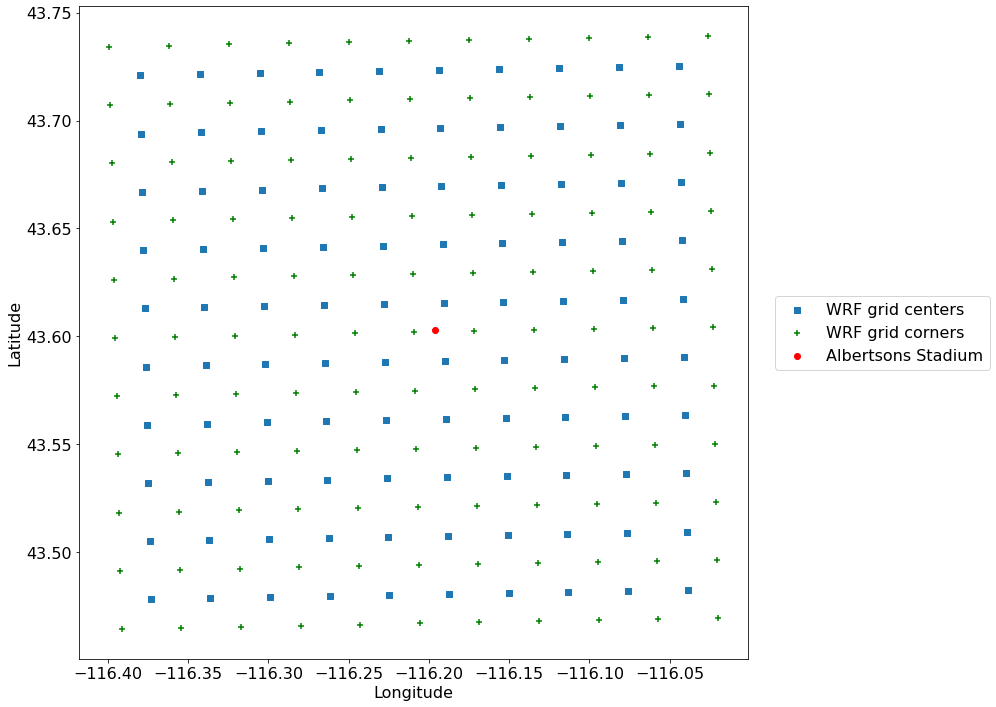

In [9]:
plt.figure(figsize=(12,12))
plt.rcParams.update({'font.size': 16})
plt.scatter(ds_grid_test.XLONG_M.values,ds_grid_test.XLAT_M.values,label='WRF grid centers',marker='s')
plt.scatter(ds_grid_test.XLONG_C.values,ds_grid_test.XLAT_C.values,label='WRF grid corners',marker='+',color='g')
plt.scatter(lon,lat, color='r',label='Albertsons Stadium')
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center', ncol=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
